# Sign Language Image Classification with Vision Transformers

In [ ]:
# import sys
# sys.path.append("/home/studio-lab-user/projects/sign-language-image-detection")

### Dataset Preprocessing  for Vision Transformer (ViT) Model

### **Load Dataset**
   - The dataset is loaded using Keras's `image_dataset_from_directory` function.
   - Images are resized to 224x224 to match the input size of the ViT model.

### **Model and Feature Extractor Loading**:
   - The Vision Transformer model `vit-tiny-patch16` is loaded from the `transformers` library.
   - The corresponding feature extractor is also loaded to preprocess images for the model.

### **Preprocessing**:
   - A `preprocess_vit` function applies the feature extractor transformations to normalize and prepare images for the ViT model.
   - The dataset is mapped to this preprocessing function with parallelization for improved performance.

### **Dataset Splitting**:
   - The dataset is split into training (70%), validation (10%), and testing (20%) subsets.


### Install packages

### Import packages

In [1]:
# Import necessary libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timm import create_model
from tqdm import tqdm
import numpy as np


c:\Users\myrto\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # Directly store the dataset (no need for split)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the subset's data directly
        data = self.dataset[idx]
        image = data['image']
        label = data['label']

        if self.transform:
            image = self.transform(image)

        return image, label


## Load dataset

In [3]:
from datasets import load_dataset

# Specify the correct path for the dataset
dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\hagrid-classification-512p-10-percent"
# dataset_path = "/content/drive/MyDrive/projects/sign-language-image-detection/sign_datasets/sign-language-gesture-images-dataset/Gesture Image Data"

# Load the dataset using the `imagefolder` format
dataset = load_dataset('imagefolder', data_dir=dataset_path)

# Print dataset details to verify
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 50698
    })
})


In [3]:


import os
import shutil
import random

# Set a seed for reproducibility
random.seed(42)

percent = 0.1

# Define the paths
source_dir = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\hagrid-classification-512p-10-percent"
target_dir = os.path.join(os.path.dirname(source_dir), f"hagrid-classification-512p-{int(percent*100)}-percent")
# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Iterate over each class folder in the source directory
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        # Get all image files in the current class folder
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        # Select percent of the images randomly
        subset_size = max(1, int(len(images) * percent))  # At least 1 image
        subset_images = random.sample(images, subset_size)
        
        # Create the corresponding class folder in the target directory
        target_class_path = os.path.join(target_dir, class_folder)
        os.makedirs(target_class_path, exist_ok=True)
        
        # Copy the selected images to the new directory
        for image in subset_images:
            src_image_path = os.path.join(class_path, image)
            dst_image_path = os.path.join(target_class_path, image)
            shutil.copy(src_image_path, dst_image_path)

print(f"{int(percent*100)}% subset of the dataset has been created at: {target_dir}")



10% subset of the dataset has been created at: D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\hagrid-classification-512p-10-percent


In [3]:
import os
import pickle
from datasets import load_dataset

# Specify dataset path
dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\hagrid-classification-512p-10-percent"
cache_file = "dataset_cache.pkl"

# Check if cached dataset exists
if os.path.exists(cache_file):
    print("Loading dataset from cache...")
    with open(cache_file, "rb") as f:
        dataset = pickle.load(f)
else:
    print("Loading dataset from source and caching it...")
    dataset = load_dataset('imagefolder', data_dir=dataset_path)
    with open(cache_file, "wb") as f:
        pickle.dump(dataset, f)

# Print dataset details to verify
print(dataset)


Loading dataset from cache...
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 507050
    })
})


In [4]:
from PIL import Image

# Set the dataset path
dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\hagrid-classification-512p\call\0a00b8b7-ea31-4288-a70c-d1e852be3167.jpeg"

# Load the image
img = Image.open(dataset_path)

# Print the image dimensions (width, height)
print(f'Image dimensions: {img.size}')



Image dimensions: (512, 512)


In [12]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_pixels = 0  # Total number of pixels across all images

    for images, _ in loader:
        # Number of pixels in the batch (batch_size x height x width)
        batch_pixels = images.size(0) * images.size(2) * images.size(3)
        total_pixels += batch_pixels

        # Sum of means for the batch (across channels)
        mean += images.sum(dim=[0, 2, 3])  # Sum over height and width
        # Sum of squared differences for the batch
        std += (images ** 2).sum(dim=[0, 2, 3])

    # Divide by the total number of pixels to get the mean
    mean /= total_pixels
    # Divide by the total number of pixels, then sqrt to get the std
    std = torch.sqrt(std / total_pixels - mean ** 2)
    return mean, std

In [13]:
def calculate_num_classes(dataset):
    labels = [example['label'] for example in dataset]
    num_classes = len(set(labels))  # Get unique labels
    return num_classes

In [14]:
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
])

In [15]:
# Ensure you're passing the correct split of the dataset to CustomDataset
train_split = dataset['train']  # Access the 'train' split of your dataset

# Create the transformed dataset
train_dataset_transformed = CustomDataset(train_split, transform=transform_resized)

# Calculate mean and std using the transformed dataset
mean, std = calculate_mean_std(train_dataset_transformed)

# Print the calculated mean and std
print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.5808, 0.5177, 0.4873])
Std: tensor([0.2502, 0.2479, 0.2459])


In [16]:
def calculate_num_classes(dataset):
    labels = [example['label'] for example in dataset]
    num_classes = len(set(labels))  # Get unique labels
    return num_classes

In [ ]:
num_classes = calculate_num_classes(train_dataset['train'])
print(f"Number of classes in the dataset: {num_classes}")

In [4]:
# mean, std = calculate_mean_std(dataset['train'])
num_classes = 18
mean = [0.5808, 0.5177, 0.4873]
std = [0.2502, 0.2479, 0.2459]

In [7]:
print(f"Number of classes: {num_classes}")
print(f" calculated mean: {mean}")
print(f" calculated std: {std}")

Number of classes: 18
 calculated mean: [0.5778126, 0.516726, 0.48417425]
 calculated std: [0.25172076, 0.24928826, 0.24764916]


In [5]:
from torch.utils.data import random_split
# Define the transform for resizing images to 224x224, including normalization
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize the image to 224x224
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean, std)  # Normalize the image with CIFAR-10 mean and std
])


total_size = len(dataset['train'])
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(
    dataset['train'], [train_size, val_size, test_size]
)

# Wrap datasets with transform
train_dataset = CustomDataset(train_dataset, transform=transform_resized)
val_dataset = CustomDataset(val_dataset, transform=transform_resized)
test_dataset = CustomDataset(test_dataset, transform=transform_resized)

# Define DataLoaders for the training, validation, and test datasets
batch_size = 64
train_loader_resized = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_resized = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_resized = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Model Training - Full Vit Training

#### Trainer Class

In [7]:
from tqdm import tqdm
import torch

class Trainer:
    def __init__(self, model, optimizer, loss_fn, device, scheduler=None):
        """
        Initialize the Trainer class.

        Args:
            model (torch.nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): Optimizer for updating weights.
            loss_fn (torch.nn.Module): Loss function.
            device (torch.device): Device to run training (CPU/GPU).
            scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Default is None.
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.scheduler = scheduler  # Optional scheduler

    def train_epoch(self, train_loader):
        """Train for one epoch and return loss and accuracy."""
        self.model.train()
        total_loss = 0
        correct = 0

        with tqdm(train_loader, desc="Training", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

                t.set_postfix(loss=loss.item())
        
        # Compute average loss and accuracy
        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct / len(train_loader.dataset)
        return avg_loss, accuracy

    @torch.no_grad()
    def evaluate(self, dataloader):
        """Evaluate the model and return loss and accuracy."""
        self.model.eval()
        total_loss = 0
        correct = 0

        with tqdm(dataloader, desc="Validating", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader.dataset)
        accuracy = correct / len(dataloader.dataset)
        return avg_loss, accuracy

    def get_current_lr(self):
        """Retrieve the current learning rate from the optimizer."""
        return self.optimizer.param_groups[0]['lr']

    def train(self, train_loader, val_loader, epochs):
        """Train the model and evaluate it after each epoch."""
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        learning_rates = []  # Track learning rate for each epoch

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            
            # Training phase
            train_loss, train_accuracy = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            # Validation phase
            val_loss, val_accuracy = self.evaluate(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            # Get the learning rate
            current_lr = self.get_current_lr()
            learning_rates.append(current_lr)
            
            # Print epoch metrics
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")
            
            # Step the scheduler, if provided
            if self.scheduler:
                self.scheduler.step(val_loss)  # Use validation loss for ReduceLROnPlateau
            
            torch.cuda.empty_cache()

        return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates




In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


In [34]:
from collections import Counter

# Assuming `train_dataset` contains labels
labels = [label for _, label in train_dataset]  # Extract labels
label_counts = Counter(labels)
print(label_counts)


Counter({16: 20665, 3: 20227, 13: 20146, 5: 20023, 7: 19918, 8: 19892, 1: 19838, 17: 19647, 9: 19627, 14: 19583, 0: 19561, 6: 19547, 15: 19466, 12: 19437, 4: 19397, 2: 19383, 10: 19363, 11: 19215})


In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=3
)

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
# 423 seconds


Epoch 1/3


Validating: 100%|██████████| 1585/1585 [32:23<00:00,  1.23s/batch]


Train Loss: 0.1501, Train Accuracy: 0.9506
Validation Loss: 0.1172, Validation Accuracy: 0.9607
Learning Rate: 0.000200
Epoch 2/3


Validating: 100%|██████████| 1585/1585 [31:42<00:00,  1.20s/batch]


Train Loss: 0.0824, Train Accuracy: 0.9728
Validation Loss: 0.0758, Validation Accuracy: 0.9746
Learning Rate: 0.000200
Epoch 3/3


Validating: 100%|██████████| 1585/1585 [33:13<00:00,  1.26s/batch]

Train Loss: 0.0658, Train Accuracy: 0.9783
Validation Loss: 0.0827, Validation Accuracy: 0.9734
Learning Rate: 0.000200
Learning rates per epoch: [0.0002, 0.0002, 0.0002]


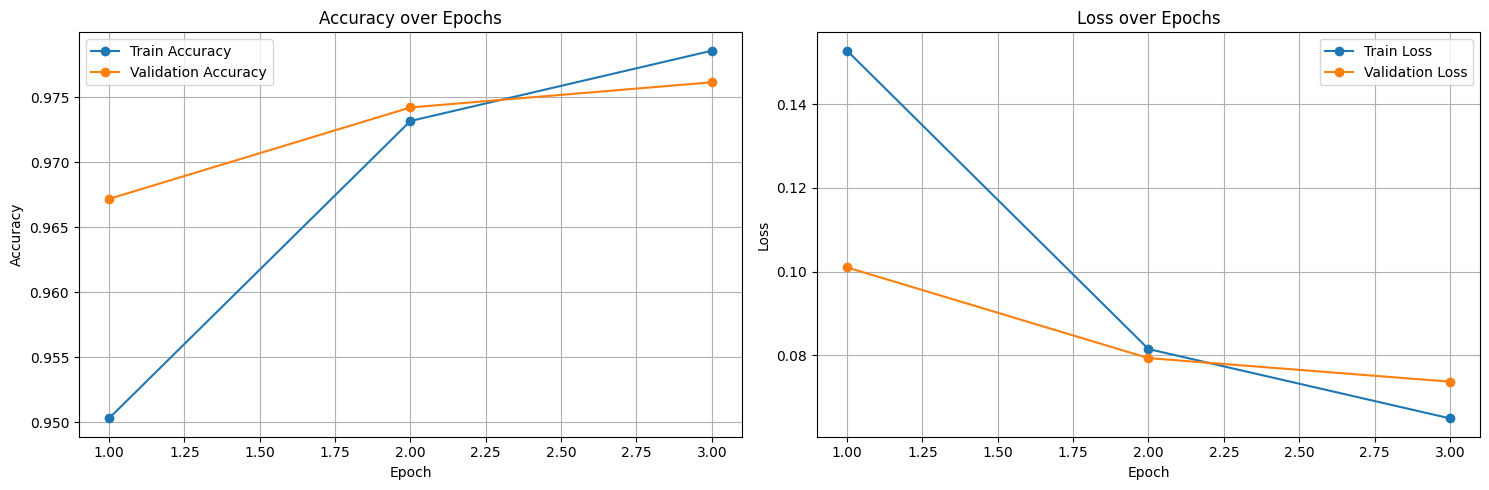

In [20]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [21]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())


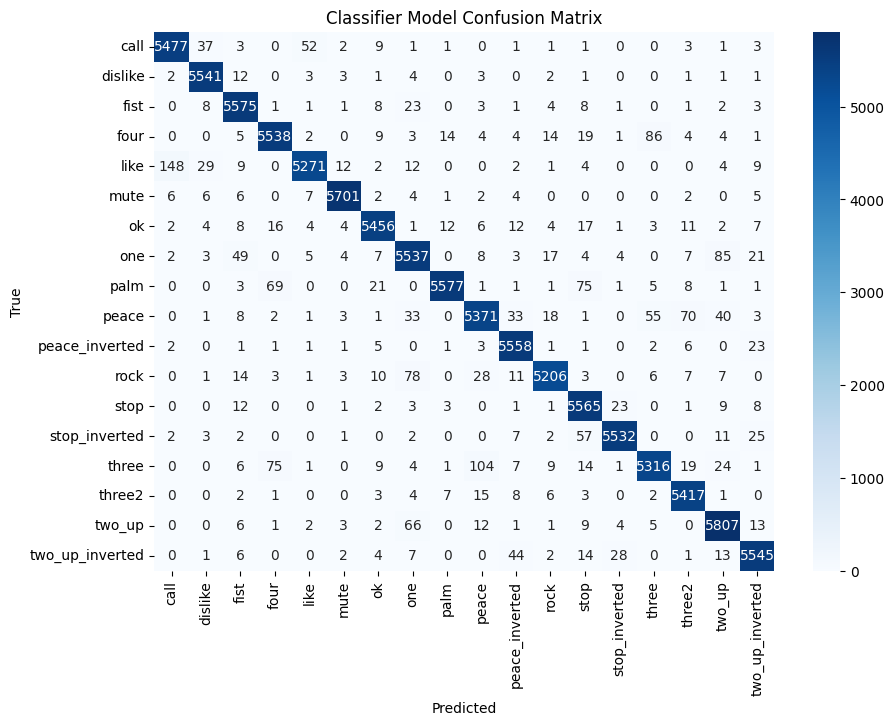

In [22]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="Classifier Model Confusion Matrix")


In [23]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 793/793 [14:30<00:00,  1.10s/batch]

Test Loss: 0.0744, Test Accuracy: 0.9761


In [11]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-3, weight_decay=1e-3
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=10
)

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)


Epoch 1/10


Validating: 100%|██████████| 1585/1585 [36:29<00:00,  1.38s/batch]


Train Loss: 1.8622, Train Accuracy: 0.4060
Validation Loss: 1.8070, Validation Accuracy: 0.4215
Learning Rate: 0.002000
Epoch 2/10


Validating: 100%|██████████| 1585/1585 [09:37<00:00,  2.75batch/s]


Train Loss: 1.8431, Train Accuracy: 0.4141
Validation Loss: 1.8452, Validation Accuracy: 0.4161
Learning Rate: 0.002000
Epoch 3/10


Validating: 100%|██████████| 1585/1585 [09:36<00:00,  2.75batch/s]


Train Loss: 1.8426, Train Accuracy: 0.4137
Validation Loss: 1.8224, Validation Accuracy: 0.4191
Learning Rate: 0.002000
Epoch 4/10


Validating: 100%|██████████| 1585/1585 [09:36<00:00,  2.75batch/s]


Train Loss: 1.8439, Train Accuracy: 0.4145
Validation Loss: 1.8375, Validation Accuracy: 0.4148
Learning Rate: 0.002000
Epoch 5/10


Validating: 100%|██████████| 1585/1585 [09:35<00:00,  2.76batch/s]


Train Loss: 1.8427, Train Accuracy: 0.4141
Validation Loss: 1.8424, Validation Accuracy: 0.4159
Learning Rate: 0.002000
Epoch 6/10


Validating: 100%|██████████| 1585/1585 [09:34<00:00,  2.76batch/s]


Train Loss: 1.8436, Train Accuracy: 0.4135
Validation Loss: 1.8834, Validation Accuracy: 0.4045
Learning Rate: 0.002000
Epoch 7/10


Validating: 100%|██████████| 1585/1585 [09:34<00:00,  2.76batch/s]


Train Loss: 1.8424, Train Accuracy: 0.4139
Validation Loss: 1.8334, Validation Accuracy: 0.4138
Learning Rate: 0.002000
Epoch 8/10


Validating: 100%|██████████| 1585/1585 [09:34<00:00,  2.76batch/s]


Train Loss: 1.8419, Train Accuracy: 0.4139
Validation Loss: 1.8645, Validation Accuracy: 0.4049
Learning Rate: 0.002000
Epoch 9/10


Validating: 100%|██████████| 1585/1585 [09:34<00:00,  2.76batch/s]


Train Loss: 1.8423, Train Accuracy: 0.4145
Validation Loss: 1.8301, Validation Accuracy: 0.4131
Learning Rate: 0.002000
Epoch 10/10


Validating: 100%|██████████| 1585/1585 [09:35<00:00,  2.76batch/s]

Train Loss: 1.8414, Train Accuracy: 0.4143
Validation Loss: 1.8167, Validation Accuracy: 0.4205
Learning Rate: 0.002000
Learning rates per epoch: [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002]


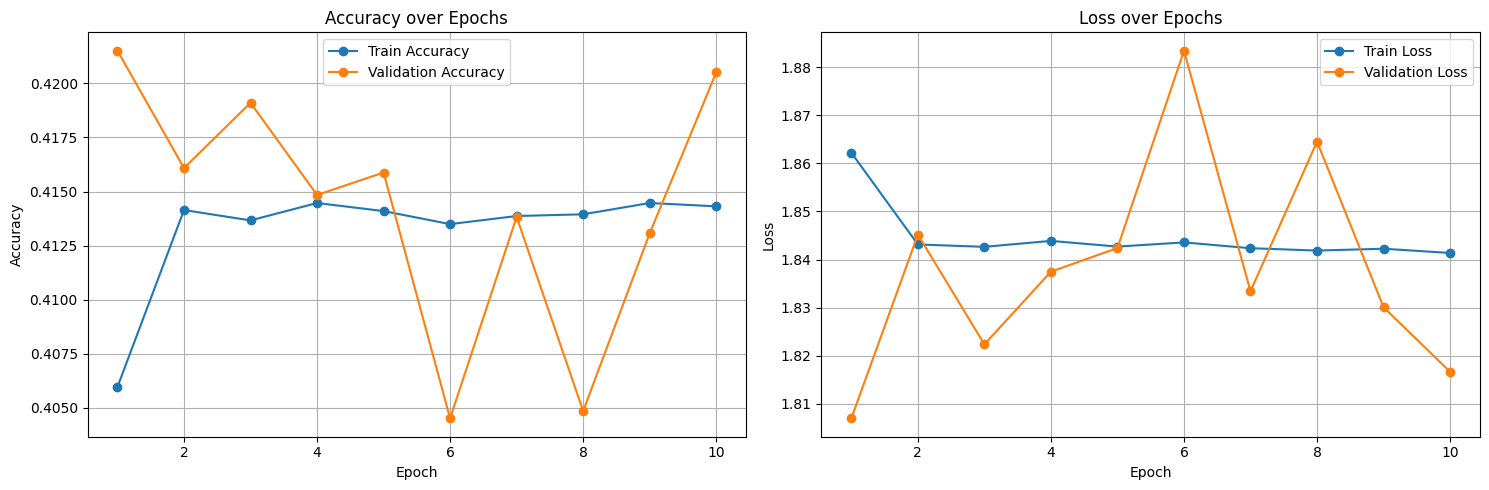

In [12]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [13]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

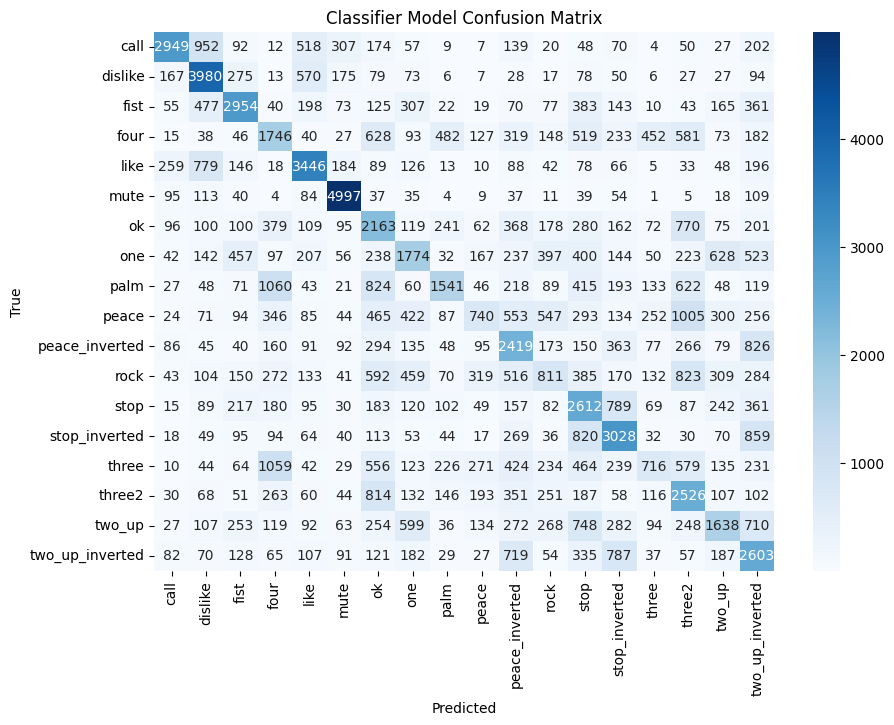

In [16]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="Classifier Model Confusion Matrix")


In [17]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)


Validating: 100%|██████████| 793/793 [18:16<00:00,  1.38s/batch]


In [18]:
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.8162, Test Accuracy: 0.4199


In [21]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_base_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=5e-4, weight_decay=1e-3
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=10 
)
# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/10


Validating: 100%|██████████| 1585/1585 [38:36<00:00,  1.46s/batch]


Train Loss: 1.0607, Train Accuracy: 0.6534
Validation Loss: 0.9049, Validation Accuracy: 0.6993
Learning Rate: 0.000500
Epoch 2/10


Validating: 100%|██████████| 1585/1585 [39:31<00:00,  1.50s/batch]


Train Loss: 0.8665, Train Accuracy: 0.7110
Validation Loss: 0.8549, Validation Accuracy: 0.7161
Learning Rate: 0.000500
Epoch 3/10


Validating: 100%|██████████| 1585/1585 [38:36<00:00,  1.46s/batch]


Train Loss: 0.8366, Train Accuracy: 0.7208
Validation Loss: 0.8421, Validation Accuracy: 0.7208
Learning Rate: 0.000500
Epoch 4/10


Validating: 100%|██████████| 1585/1585 [38:28<00:00,  1.46s/batch]


Train Loss: 0.8238, Train Accuracy: 0.7244
Validation Loss: 0.8383, Validation Accuracy: 0.7223
Learning Rate: 0.000500
Epoch 5/10


Validating: 100%|██████████| 1585/1585 [38:32<00:00,  1.46s/batch]


Train Loss: 0.8166, Train Accuracy: 0.7271
Validation Loss: 0.8355, Validation Accuracy: 0.7215
Learning Rate: 0.000500
Epoch 6/10


Validating: 100%|██████████| 1585/1585 [1:02:08<00:00,  2.35s/batch]


Train Loss: 0.8126, Train Accuracy: 0.7280
Validation Loss: 0.8293, Validation Accuracy: 0.7256
Learning Rate: 0.000500
Epoch 7/10


Validating: 100%|██████████| 1585/1585 [1:03:10<00:00,  2.39s/batch]


Train Loss: 0.8105, Train Accuracy: 0.7292
Validation Loss: 0.8267, Validation Accuracy: 0.7257
Learning Rate: 0.000500
Epoch 8/10


Validating: 100%|██████████| 1585/1585 [1:03:52<00:00,  2.42s/batch]


Train Loss: 0.8081, Train Accuracy: 0.7299
Validation Loss: 0.8277, Validation Accuracy: 0.7259
Learning Rate: 0.000500
Epoch 9/10


Validating: 100%|██████████| 1585/1585 [59:06<00:00,  2.24s/batch]


Train Loss: 0.8072, Train Accuracy: 0.7294
Validation Loss: 0.8263, Validation Accuracy: 0.7256
Learning Rate: 0.000500
Epoch 10/10


Validating: 100%|██████████| 1585/1585 [1:04:38<00:00,  2.45s/batch]

Train Loss: 0.8051, Train Accuracy: 0.7314
Validation Loss: 0.8297, Validation Accuracy: 0.7259
Learning Rate: 0.000500
Learning rates per epoch: [0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005]
Training completed in: 133708.39 seconds


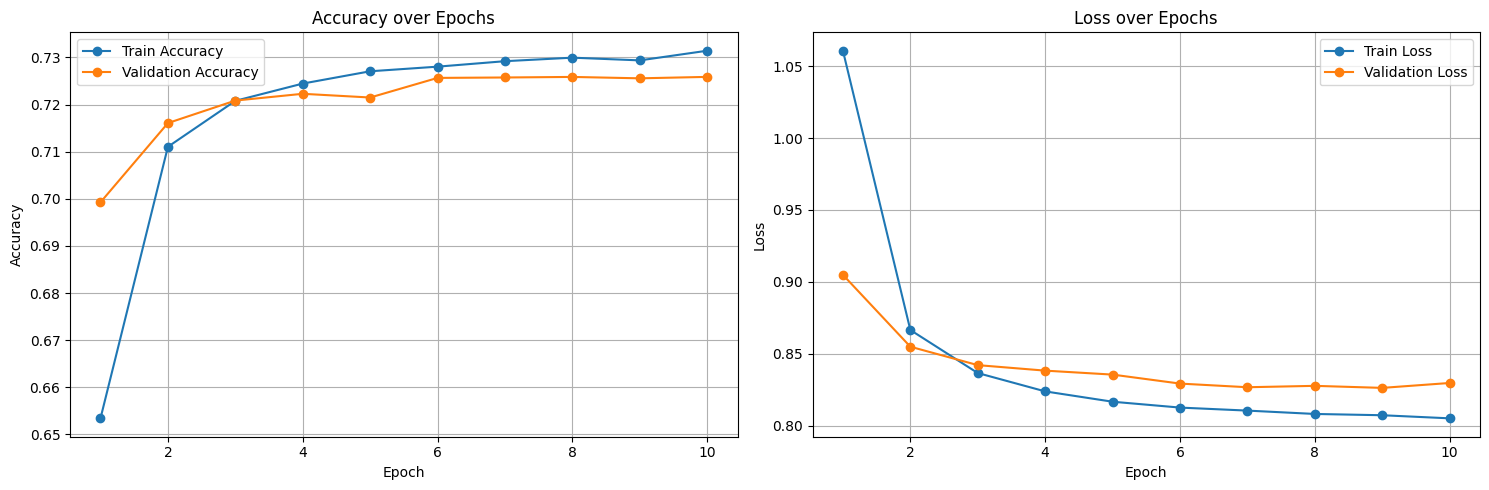

In [22]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [23]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

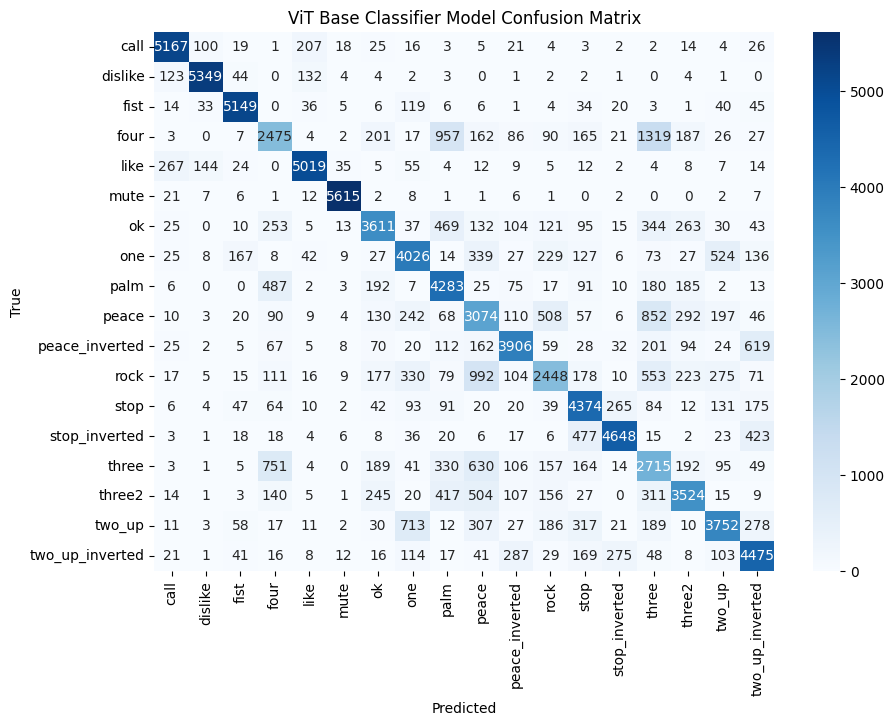

In [24]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="ViT Base Classifier Model Confusion Matrix")


In [25]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 793/793 [30:27<00:00,  2.30s/batch]

Test Loss: 0.8193, Test Accuracy: 0.7281


In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "efficientvit_m5.r224_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=3
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/3


Validating: 100%|██████████| 159/159 [01:53<00:00,  1.40batch/s]


Train Loss: 1.0521, Train Accuracy: 0.7313
Validation Loss: 0.2579, Validation Accuracy: 0.9258
Learning Rate: 0.000200
Epoch 2/3


Validating: 100%|██████████| 159/159 [00:46<00:00,  3.42batch/s]


Train Loss: 0.1709, Train Accuracy: 0.9506
Validation Loss: 0.1582, Validation Accuracy: 0.9525
Learning Rate: 0.000200
Epoch 3/3


Validating: 100%|██████████| 159/159 [00:47<00:00,  3.37batch/s]

Train Loss: 0.0836, Train Accuracy: 0.9752
Validation Loss: 0.1593, Validation Accuracy: 0.9536
Learning Rate: 0.000200
Learning rates per epoch: [0.0002, 0.0002, 0.0002]
Training completed in: 1270.07 seconds


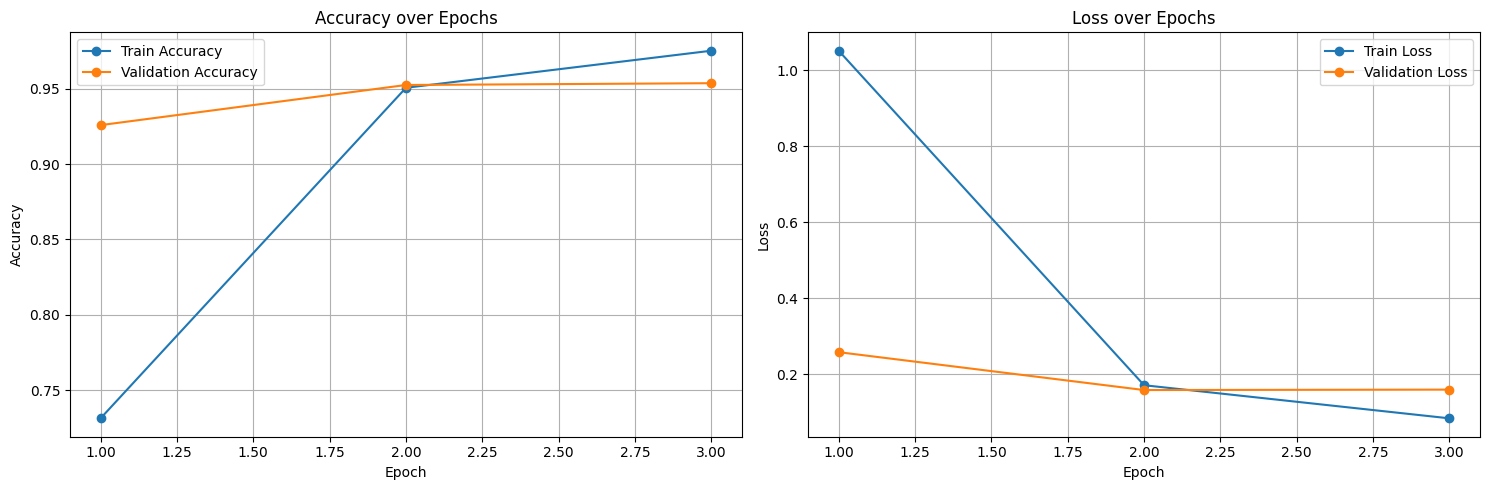

In [11]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [12]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

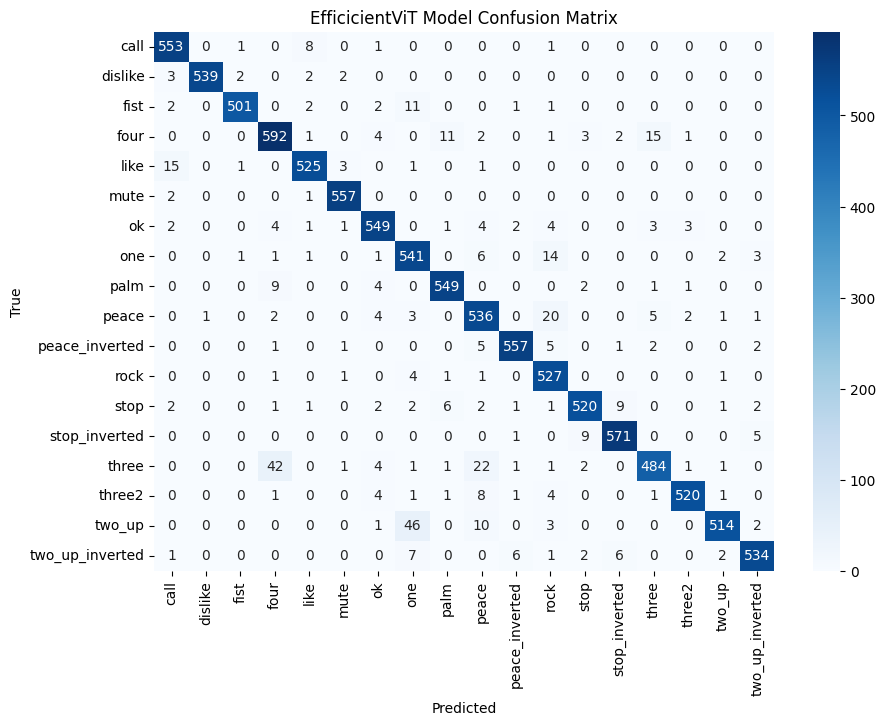

In [13]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="EfficicientViT Model Confusion Matrix")


In [14]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 80/80 [00:57<00:00,  1.40batch/s]

Test Loss: 0.1492, Test Accuracy: 0.9533


In [15]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "deit3_small_patch16_224.fb_in22k_ft_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=1
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/1


Validating: 100%|██████████| 159/159 [01:53<00:00,  1.40batch/s]

Train Loss: 0.2982, Train Accuracy: 0.9034
Validation Loss: 0.1357, Validation Accuracy: 0.9558
Learning Rate: 0.000200
Learning rates per epoch: [0.0002]
Training completed in: 2279.13 seconds


In [16]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

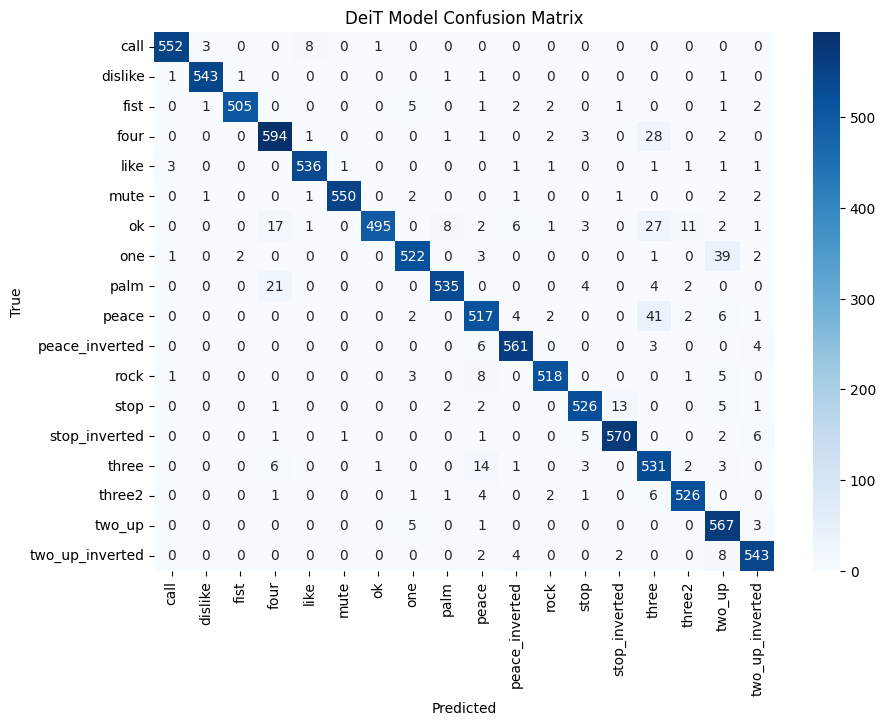

In [17]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="DeiT Model Confusion Matrix")


In [18]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 80/80 [00:49<00:00,  1.62batch/s]

Test Loss: 0.1264, Test Accuracy: 0.9592
